<a href="https://colab.research.google.com/github/teamgaon/lg_farm/blob/main/220201_sm_ensemble_8.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

성능 : 0.93504

이 코드가 뭐냐면

k-fold로 앙상블한 모델 5개로 예측

학습은 사진을 뒤집고 돌리고 한 augmentation 데이터로 학습

근데 tta는 성능이 안나와서 tta는 빼고 돌린 코드임

In [1]:
!pip install ttach
!pip install albumentations==0.4.6

     |████████████████████████████████| 117 kB 4.3 MB/s 
     |████████████████████████████████| 948 kB 29.1 MB/s 
  Created wheel for albumentations: filename=albumentations-0.4.6-py3-none-any.whl size=65174 sha256=f616b8d5c52422cc1528266521284ef0e5e7f4334152c3ce789bcaf1cb9e3b9f
  Stored in directory: /root/.cache/pip/wheels/cf/34/0f/cb2a5f93561a181a4bcc84847ad6aaceea8b5a3127469616cc
Successfully built albumentations
  Attempting uninstall: imgaug
    Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9
  Attempting uninstall: albumentations
    Found existing installation: albumentations 0.1.12
    Uninstalling albumentations-0.1.12:
      Successfully uninstalled albumentations-0.1.12


## 할 일

plant-doc dataset으로 pretrain

대회 데이터로 finetune

b2, b4 비교

In [2]:
!nvidia-smi
# k80 -> T4 -> P100

Tue Feb  1 04:39:50 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.46       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   32C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

# 사용 패키지

In [3]:
import albumentations
import albumentations.pytorch
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import cv2
from tqdm import tqdm
from glob import glob
import os
import json
import torch
from torch import nn
from torchvision import models
from torch.utils.data import Dataset
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
import ttach as tta
import albumentations as A
# from albumentations.pytorch import ToTensor
from sklearn.model_selection import KFold
from albumentations.pytorch import ToTensorV2

In [4]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [5]:
!unzip /content/drive/MyDrive/LG/train.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
   creating: train/55844/
  inflating: train/55844/55844.csv   
  inflating: train/55844/55844.jpg   
  inflating: train/55844/55844.json  
   creating: train/55847/
  inflating: train/55847/55847.csv   
  inflating: train/55847/55847.jpg   
  inflating: train/55847/55847.json  
   creating: train/55848/
  inflating: train/55848/55848.csv   
  inflating: train/55848/55848.jpg   
  inflating: train/55848/55848.json  
   creating: train/55858/
  inflating: train/55858/55858.csv   
  inflating: train/55858/55858.jpg   
  inflating: train/55858/55858.json  
   creating: train/55870/
  inflating: train/55870/55870.csv   
  inflating: train/55870/55870.jpg   
  inflating: train/55870/55870.json  
   creating: train/55889/
  inflating: train/55889/55889.csv   
  inflating: train/55889/55889.jpg   
  inflating: train/55889/55889.json  
   creating: train/55895/
  inflating: train/55895/55895.csv   
  inflating: train/55895/55895.jpg   
  inflating: train/558

In [6]:
# !zip -FFv /content/drive/MyDrive/LG/test.zip --out test2.zip

In [7]:
!unzip /content/drive/MyDrive/LG/test.zip

스트리밍 출력 내용이 길어서 마지막 5000줄이 삭제되었습니다.
  inflating: test/65823/65823.csv    
  inflating: test/65823/65823.jpg    
   creating: test/65824/
  inflating: test/65824/65824.jpg    
  inflating: test/65824/65824.csv    
   creating: test/65825/
  inflating: test/65825/65825.csv    
  inflating: test/65825/65825.jpg    
   creating: test/65827/
  inflating: test/65827/65827.jpg    
  inflating: test/65827/65827.csv    
   creating: test/65828/
  inflating: test/65828/65828.jpg    
  inflating: test/65828/65828.csv    
   creating: test/65829/
  inflating: test/65829/65829.jpg    
  inflating: test/65829/65829.csv    
   creating: test/65830/
  inflating: test/65830/65830.jpg    
  inflating: test/65830/65830.csv    
   creating: test/65831/
  inflating: test/65831/65831.jpg    
  inflating: test/65831/65831.csv    
   creating: test/65832/
  inflating: test/65832/65832.jpg    
  inflating: test/65832/65832.csv    
   creating: test/65833/
  inflating: test/65833/65833.jpg    
  inflating: test

# 데이터 살펴보기

In [8]:
sample = glob('/content/train/*')[42]

sample_csv = pd.read_csv(glob(sample+'/*.csv')[0])
sample_image = cv2.imread(glob(sample+'/*.jpg')[0])
sample_json = json.load(open(glob(sample+'/*.json')[0], 'r'))

In [9]:
from datetime import datetime, timedelta

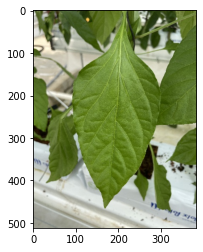

In [10]:
# image
plt.imshow(cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB))
plt.show()

In [11]:
# json
sample_json

{'annotations': {'area': 3,
  'bbox': [{'h': 411.8321552579365,
    'w': 208.25982762896825,
    'x': 91.74146670386905,
    'y': 54.91095455109127}],
  'crop': 5,
  'disease': 'b6',
  'grow': 13,
  'part': [{'h': 389.733878968254,
    'id': 0,
    'w': 191.51869419642858,
    'x': 100.44686259920636,
    'y': 66.96458023313492}],
  'risk': 1},
 'description': {'date': '20211102',
  'height': 512,
  'image': '10880.jpg',
  'region': 0,
  'task': 2,
  'time': '1159',
  'width': 384}}

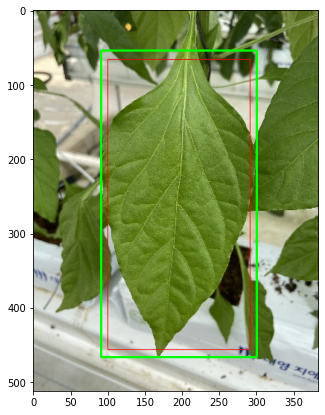

In [12]:
# visualize bbox
plt.figure(figsize=(7,7))
points = sample_json['annotations']['bbox'][0]
part_points = sample_json['annotations']['part']
img = cv2.cvtColor(sample_image, cv2.COLOR_BGR2RGB)

cv2.rectangle(
    img,
    (int(points['x']), int(points['y'])),
    (int((points['x']+points['w'])), int((points['y']+points['h']))),
    (0, 255, 0),
    2
)
for part_point in part_points:
    point = part_point
    cv2.rectangle(
        img,
        (int(point['x']), int(point['y'])),
        (int((point['x']+point['w'])), int((point['y']+point['h']))),
        (255, 0, 0),
        1
    )
plt.imshow(img)
plt.show()

# 데이터 로드

## 환경 데이터 통계량 계산 for MinMax Scaling

In [13]:
# 분석에 사용할 feature 선택
csv_features = ['내부 온도 1 평균', '내부 온도 1 최고', '내부 온도 1 최저', '내부 습도 1 평균', '내부 습도 1 최고', 
                '내부 습도 1 최저', '내부 이슬점 평균', '내부 이슬점 최고', '내부 이슬점 최저']

csv_files = sorted(glob('/content/train/*/*.csv'))

temp_csv = pd.read_csv(csv_files[0])[csv_features]
max_arr, min_arr = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()

# feature 별 최대값, 최솟값 계산
for csv in tqdm(csv_files[1:]):
    temp_csv = pd.read_csv(csv)[csv_features]
    temp_csv = temp_csv.replace('-',np.nan).dropna()
    if len(temp_csv) == 0:
        continue
    temp_csv = temp_csv.astype(float)
    temp_max, temp_min = temp_csv.max().to_numpy(), temp_csv.min().to_numpy()
    max_arr = np.max([max_arr,temp_max], axis=0)
    min_arr = np.min([min_arr,temp_min], axis=0)

# feature 별 최대값, 최솟값 dictionary 생성
csv_feature_dict = {csv_features[i]:[min_arr[i], max_arr[i]] for i in range(len(csv_features))}
csv_feature_dict

100%|██████████| 5766/5766 [00:50<00:00, 113.72it/s]


{'내부 습도 1 최고': [25.9, 100.0],
 '내부 습도 1 최저': [0.0, 100.0],
 '내부 습도 1 평균': [23.7, 100.0],
 '내부 온도 1 최고': [3.4, 47.6],
 '내부 온도 1 최저': [3.3, 47.0],
 '내부 온도 1 평균': [3.4, 47.3],
 '내부 이슬점 최고': [0.2, 34.7],
 '내부 이슬점 최저': [0.0, 34.4],
 '내부 이슬점 평균': [0.1, 34.5]}

## CustomDataset 제작

In [14]:
# 변수 설명 csv 파일 참조
crop = {'1':'딸기','2':'토마토','3':'파프리카','4':'오이','5':'고추','6':'시설포도'}
disease = {'1':{'a1':'딸기잿빛곰팡이병','a2':'딸기흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '2':{'a5':'토마토흰가루병','a6':'토마토잿빛곰팡이병','b2':'열과','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '3':{'a9':'파프리카흰가루병','a10':'파프리카잘록병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '4':{'a3':'오이노균병','a4':'오이흰가루병','b1':'냉해피해','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '5':{'a7':'고추탄저병','a8':'고추흰가루병','b3':'칼슘결핍','b6':'다량원소결핍 (N)','b7':'다량원소결핍 (P)','b8':'다량원소결핍 (K)'},
           '6':{'a11':'시설포도탄저병','a12':'시설포도노균병','b4':'일소피해','b5':'축과병'}}
risk = {'1':'초기','2':'중기','3':'말기'}

In [15]:
label_description = {}
for key, value in disease.items():
    label_description[f'{key}_00_0'] = f'{crop[key]}_정상'
    for disease_code in value:
        for risk_code in risk:
            label = f'{key}_{disease_code}_{risk_code}'
            label_description[label] = f'{crop[key]}_{disease[key][disease_code]}_{risk[risk_code]}'
list(label_description.items())[:10]

[('1_00_0', '딸기_정상'),
 ('1_a1_1', '딸기_딸기잿빛곰팡이병_초기'),
 ('1_a1_2', '딸기_딸기잿빛곰팡이병_중기'),
 ('1_a1_3', '딸기_딸기잿빛곰팡이병_말기'),
 ('1_a2_1', '딸기_딸기흰가루병_초기'),
 ('1_a2_2', '딸기_딸기흰가루병_중기'),
 ('1_a2_3', '딸기_딸기흰가루병_말기'),
 ('1_b1_1', '딸기_냉해피해_초기'),
 ('1_b1_2', '딸기_냉해피해_중기'),
 ('1_b1_3', '딸기_냉해피해_말기')]

In [16]:
label_encoder = {key:idx for idx, key in enumerate(label_description)}
label_decoder = {val:key for key, val in label_encoder.items()}

In [17]:
class CustomDataset(Dataset):
    def __init__(self, files, labels=None, mode='train', transforms=None):
        self.mode = mode
        self.files = files
        self.csv_feature_dict = csv_feature_dict
        self.csv_feature_check = [0]*len(self.files)
        self.csv_features = [None]*len(self.files)
        self.max_len = 24 * 6
        self.label_encoder = label_encoder
        self.transforms = transforms

    def __len__(self):
        return len(self.files)
    
    def __getitem__(self, i):
        file = self.files[i]
        file_name = file.split('/')[-1]
        
        # csv
        if self.csv_feature_check[i] == 0:
            csv_path = f'{file}/{file_name}.csv'
            df = pd.read_csv(csv_path)
            df['측정시각'] = pd.to_datetime(df['측정시각'])
            df = df.sort_values(by='측정시각')
            df = df[self.csv_feature_dict.keys()]
            df = df.replace('-', 0)
            # MinMax scaling
            for col in df.columns:
                df[col] = df[col].astype(float) - self.csv_feature_dict[col][0]
                df[col] = df[col] / (self.csv_feature_dict[col][1]-self.csv_feature_dict[col][0])
            # zero padding
            pad = np.zeros((self.max_len, len(df.columns)))
            length = min(self.max_len, len(df))
            pad[-length:] = df.to_numpy()[-length:]
            # transpose to sequential data
            csv_feature = pad.T
            self.csv_features[i] = csv_feature
            self.csv_feature_check[i] = 1
        else:
            csv_feature = self.csv_features[i]
        
        # image
        image_path = f'{file}/{file_name}.jpg'
        img = cv2.imread(image_path)
        # img = cv2.resize(img, dsize=(512, 512), interpolation=cv2.INTER_AREA)
        # img = img.astype(np.float32)/255
        # img = np.transpose(img, (2,0,1))
        if self.transforms is not None:
          img = self.transforms(image=img)['image']
        
        if self.mode == 'train':
            json_path = f'{file}/{file_name}.json'
            with open(json_path, 'r') as f:
                json_file = json.load(f)
            
            crop = json_file['annotations']['crop']
            disease = json_file['annotations']['disease']
            risk = json_file['annotations']['risk']
            label = f'{crop}_{disease}_{risk}'

            # augmentation = random.randint(0,2)
            # if augmentation==1:
            #     img = img[::-1].copy()
            # elif augmentation==2:
            #     img = img[:,::-1].copy()
            # img = transforms.ToTensor()(img)
            
            return {
                'img' : img,
                #torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32),
                'label' : torch.tensor(self.label_encoder[label], dtype=torch.long)
            }
        else:
            return {
                'img' : torch.tensor(img, dtype=torch.float32),
                'csv_feature' : torch.tensor(csv_feature, dtype=torch.float32)
            }

# 하이퍼파라미터 및 변수

In [18]:
device = torch.device("cuda:0")
batch_size = 8
class_n = len(label_encoder)
learning_rate = 1e-4
embedding_dim = 528
height = 528
width = 528
num_features = len(csv_feature_dict)
max_len = 24*6
dropout_rate = 0.1
epochs = 15
k_folds = 5
vision_pretrain = True
save_path = '/content/drive/MyDrive/LG/'

# 데이터셋 구성

In [19]:
train = sorted(glob('/content/train/*'))
test = sorted(glob('/content/test/*'))

labelsss = pd.read_csv('/content/drive/MyDrive/LG/train.csv')['label']
# train, val = train_test_split(train, test_size=0.2, stratify=labelsss)

In [20]:
train_transforms = A.Compose([
        A.Resize(height=height, width=width, interpolation=cv2.INTER_CUBIC),
        A.HorizontalFlip(p=0.5),
        A.VerticalFlip(p=0.5),
        A.Rotate(25, interpolation=cv2.INTER_CUBIC),
        A.Normalize([0.4419, 0.5274, 0.3488], [0.2152, 0.1902, 0.2384]),
        ToTensorV2(),
])

In [21]:
test_transforms = A.Compose([
        A.Resize(height=height, width=width, interpolation=cv2.INTER_CUBIC),
        A.Normalize([0.4419, 0.5274, 0.3488], [0.2152, 0.1902, 0.2384]),
        ToTensorV2(),
    ])

In [22]:
train_dataset = CustomDataset(train, transforms = train_transforms)
# val_dataset = CustomDataset(val)
test_dataset = CustomDataset(test, mode = 'test', transforms = test_transforms)

# train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, num_workers=2, shuffle=True)
# val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=batch_size, num_workers=2, shuffle=False)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=batch_size, num_workers=2, shuffle=False)

# 모델

## 이미지 분류 모델 : efficientnet_b7 -> b4 -> b2 -> b4 -> b6

In [23]:
class CNN_Encoder(nn.Module):
    def __init__(self, class_n, rate=0.1):
        super(CNN_Encoder, self).__init__()
        self.model = models.efficientnet_b6(pretrained=True)
    
    def forward(self, inputs):
        output = self.model(inputs)
        return output

## 시계열 모델 : LSTM

In [24]:
class RNN_Decoder(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(RNN_Decoder, self).__init__()
        self.lstm = nn.LSTM(max_len, embedding_dim)
        self.rnn_fc = nn.Linear(num_features*embedding_dim, 100)
        self.final_layer = nn.Linear(100 + 1000, class_n) # resnet out_dim + lstm out_dim
        self.dropout = nn.Dropout(rate)

    def forward(self, enc_out, dec_inp):
        hidden, _ = self.lstm(dec_inp)
        hidden = hidden.view(hidden.size(0), -1)
        hidden = self.rnn_fc(hidden)
        concat = torch.cat([enc_out, hidden], dim=1) # enc_out + hidden 
        fc_input = concat
        output = self.dropout((self.final_layer(fc_input)))
        return output

## 앙상블

In [25]:
class CNN2RNN(nn.Module):
    def __init__(self, max_len, embedding_dim, num_features, class_n, rate):
        super(CNN2RNN, self).__init__()
        self.cnn = CNN_Encoder(embedding_dim, rate)
        self.rnn = RNN_Decoder(max_len, embedding_dim, num_features, class_n, rate)
        
    def forward(self, img, seq):
        cnn_output = self.cnn(img)
        output = self.rnn(cnn_output, seq)
        
        return output

In [26]:
# model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
# model = model.to(device)

# 학습

In [27]:
# optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
#                                         lr_lambda=lambda epoch: 0.95 ** epoch,
#                                         last_epoch=-1,
#                                         verbose=False)

# criterion = nn.CrossEntropyLoss()

In [28]:
def accuracy_function(real, pred):    
    real = real.cpu()
    pred = torch.argmax(pred, dim=1).cpu()
    score = f1_score(real, pred, average='macro')
    return score

def train_step(batch_item, training):
    img = batch_item['img'].to(device)
    csv_feature = batch_item['csv_feature'].to(device)
    label = batch_item['label'].to(device)
    if training is True:
        model.train()
        optimizer.zero_grad()
        with torch.cuda.amp.autocast():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        loss.backward()
        optimizer.step()
        score = accuracy_function(label, output)
        return loss, score
    else:
        model.eval()
        with torch.no_grad():
            output = model(img, csv_feature)
            loss = criterion(output, label)
        score = accuracy_function(label, output)
        return loss, score

In [29]:
import random
import torchvision.transforms as transforms
import gc

In [30]:
gc.collect()

5178

In [ ]:
# loss_plot, val_loss_plot = [], []
# metric_plot, val_metric_plot = [], []
      
# Define the K-fold Cross Validator
kfold = KFold(n_splits=k_folds, shuffle=True)
  
# Start print
print('--------------------------------')

# K-fold Cross Validation model evaluation
for fold, (train_ids, test_ids) in enumerate(kfold.split(train_dataset)):
  gc.collect()
  loss_plot, val_loss_plot = [], []
  metric_plot, val_metric_plot = [], []
  
  # Print
  print('')
  print(f'FOLD {fold}')
  print('--------------------------------')
  
  # Sample elements randomly from a given list of ids, no replacement.
  train_subsampler = torch.utils.data.SubsetRandomSampler(train_ids)
  test_subsampler = torch.utils.data.SubsetRandomSampler(test_ids)
  
  # Define data loaders for training and testing data in this fold
  train_dataloader = torch.utils.data.DataLoader(
                    train_dataset, 
                    batch_size=batch_size, sampler=train_subsampler, num_workers=2)
  val_dataloader = torch.utils.data.DataLoader(
                    train_dataset,
                    batch_size=batch_size, sampler=test_subsampler, num_workers=2)
  
  model = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
  model = model.to(device)

  optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

  scheduler = torch.optim.lr_scheduler.LambdaLR(optimizer=optimizer,
                                          lr_lambda=lambda epoch: 0.95 ** epoch,
                                          last_epoch=-1,
                                          verbose=False)

  criterion = nn.CrossEntropyLoss()
  
  for epoch in range(epochs):
      total_loss, total_val_loss = 0, 0
      total_acc, total_val_acc = 0, 0
      
      tqdm_dataset = tqdm(enumerate(train_dataloader))
      training = True
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_loss += batch_loss
          total_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Loss' : '{:06f}'.format(total_loss/(batch+1)),
              'Mean F-1' : '{:06f}'.format(total_acc/(batch+1))
          })
      loss_plot.append(total_loss/(batch+1))
      metric_plot.append(total_acc/(batch+1))
      
      tqdm_dataset = tqdm(enumerate(val_dataloader))
      training = False
      for batch, batch_item in tqdm_dataset:
          batch_loss, batch_acc = train_step(batch_item, training)
          total_val_loss += batch_loss
          total_val_acc += batch_acc
          
          tqdm_dataset.set_postfix({
              'Epoch': epoch + 1,
              'Val Loss': '{:06f}'.format(batch_loss.item()),
              'Mean Val Loss' : '{:06f}'.format(total_val_loss/(batch+1)),
              'Mean Val F-1' : '{:06f}'.format(total_val_acc/(batch+1))
          })
      val_loss_plot.append(total_val_loss/(batch+1))
      val_metric_plot.append(total_val_acc/(batch+1))
      scheduler.step()

      if np.max(val_metric_plot) == val_metric_plot[-1]:
          torch.save(model.state_dict(), save_path+'best_model'+str(fold)+'.pt')
          print('best')

      

--------------------------------

FOLD 0
--------------------------------


Downloading: "https://download.pytorch.org/models/efficientnet_b6_lukemelas-c76e70fd.pth" to /root/.cache/torch/hub/checkpoints/efficientnet_b6_lukemelas-c76e70fd.pth


  0%|          | 0.00/165M [00:00<?, ?B/s]

577it [07:17,  1.32it/s, Epoch=1, Loss=1.578076, Mean Loss=1.137103, Mean F-1=0.579626]
145it [00:40,  3.56it/s, Epoch=1, Val Loss=0.000269, Mean Val Loss=0.249529, Mean Val F-1=0.822635]


best


577it [07:13,  1.33it/s, Epoch=2, Loss=0.167019, Mean Loss=0.593309, Mean F-1=0.704292]
145it [00:40,  3.54it/s, Epoch=2, Val Loss=0.000215, Mean Val Loss=0.165104, Mean Val F-1=0.890636]


best


577it [07:13,  1.33it/s, Epoch=3, Loss=0.094203, Mean Loss=0.461516, Mean F-1=0.751985]
145it [00:40,  3.57it/s, Epoch=3, Val Loss=0.003368, Mean Val Loss=0.112213, Mean Val F-1=0.911089]


best


577it [07:14,  1.33it/s, Epoch=4, Loss=0.040262, Mean Loss=0.408017, Mean F-1=0.782564]
145it [00:40,  3.58it/s, Epoch=4, Val Loss=0.000021, Mean Val Loss=0.069717, Mean Val F-1=0.940361]


best


577it [07:14,  1.33it/s, Epoch=5, Loss=0.000516, Mean Loss=0.374913, Mean F-1=0.797543]
145it [00:40,  3.54it/s, Epoch=5, Val Loss=1.053715, Mean Val Loss=0.109475, Mean Val F-1=0.938216]
577it [07:14,  1.33it/s, Epoch=6, Loss=1.576797, Mean Loss=0.332871, Mean F-1=0.818049]
145it [00:40,  3.56it/s, Epoch=6, Val Loss=0.000002, Mean Val Loss=0.055539, Mean Val F-1=0.952129]


best


577it [07:16,  1.32it/s, Epoch=7, Loss=1.010041, Mean Loss=0.307533, Mean F-1=0.832527]
145it [00:41,  3.53it/s, Epoch=7, Val Loss=0.000054, Mean Val Loss=0.084529, Mean Val F-1=0.948528]
577it [07:14,  1.33it/s, Epoch=8, Loss=0.346413, Mean Loss=0.318023, Mean F-1=0.822863]
145it [00:40,  3.55it/s, Epoch=8, Val Loss=0.000011, Mean Val Loss=0.121080, Mean Val F-1=0.935383]
577it [07:14,  1.33it/s, Epoch=9, Loss=0.548088, Mean Loss=0.279693, Mean F-1=0.842643]
145it [00:41,  3.49it/s, Epoch=9, Val Loss=0.208407, Mean Val Loss=0.065409, Mean Val F-1=0.953492]


best


577it [07:14,  1.33it/s, Epoch=10, Loss=0.044996, Mean Loss=0.280693, Mean F-1=0.838410]
145it [00:41,  3.53it/s, Epoch=10, Val Loss=0.451749, Mean Val Loss=0.109382, Mean Val F-1=0.942433]
577it [07:17,  1.32it/s, Epoch=11, Loss=0.572992, Mean Loss=0.292123, Mean F-1=0.832218]
145it [00:42,  3.38it/s, Epoch=11, Val Loss=0.000025, Mean Val Loss=0.069231, Mean Val F-1=0.964107]


best


527it [06:37,  1.33it/s, Epoch=12, Loss=0.478142, Mean Loss=0.288108, Mean F-1=0.838388]

# 추론

In [ ]:
batch_size = 16

In [ ]:
# transforms = tta.Compose(
#     [
#         tta.HorizontalFlip(),
#         tta.VerticalFlip(),
#         tta.Rotate90(angles=[0, 180])
#         # tta.Scale(scales=[1, 2, 4]),
#         # tta.Multiply(factors=[0.9, 1, 1.1]),
#     ]
# )

In [ ]:
def predict(dataset, model0, model1, model2, model3, model4):
    model0.eval()
    model1.eval()
    model2.eval()
    model3.eval()
    model4.eval()
    tqdm_dataset = tqdm(enumerate(dataset))
    results = []
    for batch, batch_item in tqdm_dataset:
        img = batch_item['img'].to(device)
        seq = batch_item['csv_feature'].to(device)
        with torch.no_grad():
            output = 0.2*model0(img, seq) + 0.2*model1(img, seq) + 0.2*model2(img, seq) + 0.2*model3(img, seq) + 0.2*model4(img, seq)
        output = torch.tensor(torch.argmax(output, dim=1), dtype=torch.int32).cpu().numpy()
        results.extend(output)
    return results

model0 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model0.load_state_dict(torch.load(save_path+'best_model'+str(0)+'.pt', map_location=device))
model0.to(device)

model1 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model1.load_state_dict(torch.load(save_path+'best_model'+str(1)+'.pt', map_location=device))
model1.to(device)

model2 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model2.load_state_dict(torch.load(save_path+'best_model'+str(2)+'.pt', map_location=device))
model2.to(device)

model3 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model3.load_state_dict(torch.load(save_path+'best_model'+str(3)+'.pt', map_location=device))
model3.to(device)

model4 = CNN2RNN(max_len=max_len, embedding_dim=embedding_dim, num_features=num_features, class_n=class_n, rate=dropout_rate)
model4.load_state_dict(torch.load(save_path+'best_model'+str(4)+'.pt', map_location=device))
model4.to(device)

preds = predict(test_dataloader, model0, model1, model2, model3, model4)

In [ ]:
preds = np.array([label_decoder[int(val)] for val in preds])

# 제출 파일 생성

In [ ]:
submission = pd.read_csv('/content/drive/MyDrive/LG/sample_submission.csv')
submission['label'] = preds
submission

In [ ]:
submission.to_csv('/content/drive/MyDrive/LG/submission.csv', index=False)

## 할일
파프리카 흰가루병인 식물의 데이터로 초기, 중기, 말기를 학습하는 모델 생성 -> model2

model1이 파프리카 흰가루병이라고 예측하면 해당 index의 testdata를 model2에 투입하고 결과를 반환

3_a9_1

token : 

c043c026a75520ff49221a9de4ce1921365caea5f13fa37e4ad58557376478ff

In [ ]:
!pip install dacon_submit_api-0.0.4-py3-none-any.whl

In [ ]:
from dacon_submit_api import dacon_submit_api 

result = dacon_submit_api.post_submission_file(
'/content/drive/MyDrive/LG/submission.csv', 
'c043c026a75520ff49221a9de4ce1921365caea5f13fa37e4ad58557376478ff', 
'235870', 
'가온', 
'220131_kfold_ensemble_with_DA')